In [1]:
import pandas as pd
import numpy as np
import itertools
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from catboost import Pool,cv
from imblearn.over_sampling import SMOTE

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """
    Принтит данные о модели(precision, recall, f1-score, support) на Train/Test
    + матрица ошибок 1,2
    """
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
    
def balance_df_by_target(df, target_name, balancing_type='oversampling'):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    if balancing_type == 'oversampling':
        
        disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

        return df.sample(frac=1) 
    
    if balancing_type == 'undersampling':
        
        major_class_sample = df[df[target_name] == major_class_name].sample(target_counts[minor_class_name])
        minor_class_sample = df[df[target_name] == minor_class_name]
        
        df = pd.concat([major_class_sample, minor_class_sample], ignore_index=True)
        
        return df.sample(frac=1) 


def show_feature_importances(feature_names, feature_importances, get_top=None):
    """
    Строит график по весам признаков
    """
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
    
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    """
    Строит инфографики:
        1. Изменения F1, precision, recall
        2. Гистограмму распределения вероятностей по каждому классу
        3. Таблица скоринга
    """
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

Пути к файлам

In [4]:
train_dummies_prep = 'train_dummies_prepared.csv'
test_dummies_prep = 'test_dummies_prepared.csv'

train_prep = 'train_prepared.csv'
test_prep = 'test_prepared.csv'

train_dummies = 'train_dummies.csv'
test_dummies = 'test_dummies.csv'

In [5]:
train_df = pd.read_csv(train_prep)
test_df = pd.read_csv(test_prep)
train_df['Years in current job'] = train_df['Years in current job'].astype('object')
test_df['Years in current job'] = test_df['Years in current job'].astype('object')
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5653 entries, 0 to 5652
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             5653 non-null   object 
 1   Annual Income              5653 non-null   float64
 2   Years in current job       5653 non-null   object 
 3   Tax Liens                  5653 non-null   float64
 4   Number of Open Accounts    5653 non-null   float64
 5   Years of Credit History    5653 non-null   float64
 6   Maximum Open Credit        5653 non-null   float64
 7   Number of Credit Problems  5653 non-null   float64
 8   Bankruptcies               5653 non-null   float64
 9   Purpose                    5653 non-null   object 
 10  Term                       5653 non-null   object 
 11  Current Loan Amount        5653 non-null   float64
 12  Current Credit Balance     5653 non-null   float64
 13  Monthly Debt               5653 non-null   float

In [6]:
train_df.iloc[0]

Home Ownership                         Own Home
Annual Income                       1.02549e+06
Years in current job                         10
Tax Liens                                     0
Number of Open Accounts                      15
Years of Credit History                    15.3
Maximum Open Credit                 1.18173e+06
Number of Credit Problems                     0
Bankruptcies                                  0
Purpose                      debt consolidation
Term                                  Long Term
Current Loan Amount                      264968
Current Credit Balance                   394972
Monthly Debt                              18373
Credit Default                                1
Id                                            1
Credit Score                                737
Name: 0, dtype: object

Уникальные значения

Формируем списки признаков

In [7]:
target_name = 'Credit Default'
train_df = train_df.drop(columns = ['Id'])
test_df = test_df.drop(columns = ['Id'])
num_features = test_df.select_dtypes(include='float64').columns.tolist()
cat_features = test_df.select_dtypes(include='object').columns.tolist()

Оценка корреляции с таргетом

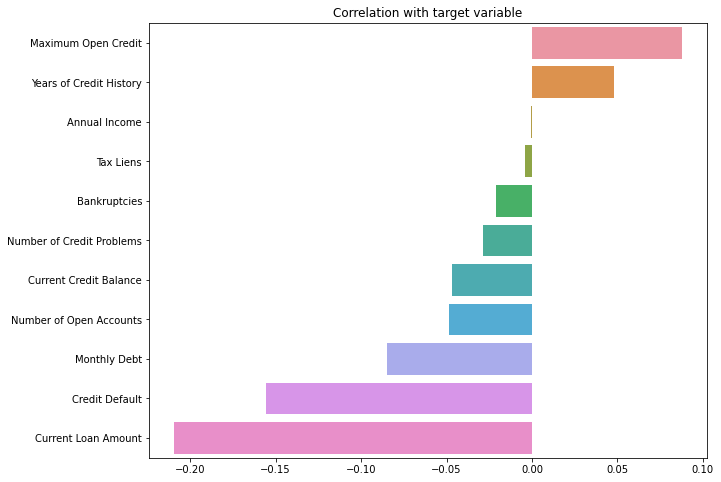

In [8]:
corr_with_target = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Корректировка значений / выведение новых признаков

##### Tax Liens

In [9]:
rep_d = {0:0, 1:1, 2:2, 3:2, 4:2, 5:2, 6:3, 7:3}

train_df['Tax Liens'].replace(rep_d, inplace=True)
test_df['Tax Liens'].replace(rep_d, inplace=True)

In [10]:
train_df['Had tax liens'] = 0
train_df.loc[train_df['Tax Liens'] != 0, 'Had tax liens'] = 1
test_df['Had tax liens'] = 0
test_df.loc[train_df['Tax Liens'] != 0, 'Had tax liens'] = 1

In [11]:
train_df['Had tax liens'].value_counts()

0    5558
1      95
Name: Had tax liens, dtype: int64

##### Term

In [12]:
train_df['Is Short Term'] = train_df['Term'].replace({'Short Term':1, 'Long Term':0})
test_df['Is Short Term'] = test_df['Term'].replace({'Short Term':1, 'Long Term':0})

##### Years in current job

In [13]:
rep_d = {'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5,
                '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10}

train_df['Years in current job'].replace(rep_d, inplace=True)
test_df['Years in current job'].replace(rep_d, inplace=True)

num_features.append('Years in current job')

##### Purpose

In [14]:
train_df['Purpose'].value_counts()

debt consolidation      4495
other                    515
home improvements        289
business loan             92
buy a car                 70
medical bills             55
major purchase            32
take a trip               30
buy house                 24
small business            22
moving                     8
wedding                    8
vacation                   7
educational expenses       6
Name: Purpose, dtype: int64

In [15]:
important_purpose = ['debt consolidation', 'other', 'home improvements', 'business loan', 'buy a car']

train_df.loc[~train_df['Purpose'].isin(important_purpose), 'Purpose'] = 'other'
test_df.loc[~test_df['Purpose'].isin(important_purpose), 'Purpose'] = 'other'

train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose'], prefix='Purpose')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Purpose'], prefix='Purpose')], axis=1)

train_df['Purpose'].value_counts()

debt consolidation    4495
other                  707
home improvements      289
business loan           92
buy a car               70
Name: Purpose, dtype: int64

In [16]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Monthly Debt,Credit Default,Credit Score,Had tax liens,Is Short Term,Purpose_business loan,Purpose_buy a car,Purpose_debt consolidation,Purpose_home improvements,Purpose_other
0,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,...,18373.0,1,737.0,0,0,0,0,1,0,0
1,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,...,11338.0,0,694.0,0,1,0,0,1,0,0
2,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,...,7180.0,0,719.0,0,1,0,0,1,0,0
3,Rent,1163256.0,7,0.0,12.0,14.6,366784.0,0.0,0.0,other,...,18692.0,1,729.0,0,0,0,0,0,0,1
4,Rent,1040060.0,10,0.0,13.0,12.0,330374.0,0.0,0.0,other,...,19761.0,1,705.0,0,1,0,0,0,0,1


In [17]:
train_df.drop(columns='Purpose_other', inplace=True)
test_df.drop(columns='Purpose_other', inplace=True)

##### Разобъем Annual Income на категории(отрезки)

In [18]:
train_df['Annual Income Cat'] = 0
train_df['Annual Income Cat'] = pd.cut(train_df['Annual Income'], 5, labels=[0, 1, 2, 3, 5])
test_df['Annual Income Cat'] = pd.cut(test_df['Annual Income'], 5, labels=[0, 1, 2, 3, 5])

train_df['Annual Income Cat'].value_counts()

1    3256
2    1129
0     752
3     377
5     139
Name: Annual Income Cat, dtype: int64

##### Выведем новые признаки для Number of Credit Problems / Bankruptcies

In [19]:
train_df['Had credit problems'] = 0
train_df['Had bankruptcies'] = 0
train_df['Had problems'] = 0

train_df.loc[train_df['Number of Credit Problems'] != 0, 'Had credit problems'] = 1
train_df.loc[train_df['Bankruptcies'] != 0, 'Had bankruptcies'] = 1
train_df.loc[(train_df['Had credit problems'] == 1) | (train_df['Had bankruptcies'] == 1), 'Had problems'] = 1

In [20]:
train_df[['Had credit problems','Had bankruptcies','Had problems']].head()

,Had credit problems,Had bankruptcies,Had problems
0,0,0,0
1,1,1,1
2,1,0,1
3,0,0,0
4,0,0,0


In [21]:
test_df['Had credit problems'] = 0
test_df['Had bankruptcies'] = 0
test_df['Had problems'] = 0

test_df.loc[test_df['Number of Credit Problems'] != 0, 'Had credit problems'] = 1
test_df.loc[test_df['Bankruptcies'] != 0, 'Had bankruptcies'] = 1
test_df.loc[(test_df['Had credit problems'] == 1) | (train_df['Had bankruptcies'] == 1), 'Had problems'] = 1

### PCA

In [22]:
important = ['Annual Income', 'Current Loan Amount', 'Credit Score', 'Maximum Open Credit', 'Monthly Debt']
n = 3
names = ['pca_' + str(i+1) for i in range(n)]

In [23]:
pca = PCA(n_components=n)

train_components = pca.fit_transform(train_df[important])
train_components = pd.DataFrame(data=train_components, columns=names)
train_df = pd.concat([train_df, train_components], axis=1)
train_components.head()
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Purpose_buy a car,Purpose_debt consolidation,Purpose_home improvements,Annual Income Cat,Had credit problems,Had bankruptcies,Had problems,pca_1,pca_2,pca_3
0,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,...,0,1,0,1,0,0,0,56927.537276,700990.695417,-141581.828913
1,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,...,0,1,0,1,1,1,1,-455579.150424,-229899.641173,-42256.696736
2,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,...,0,1,0,1,1,0,1,-418132.166214,4009.374152,-81968.170475
3,Rent,1163256.0,7,0.0,12.0,14.6,366784.0,0.0,0.0,other,...,0,0,0,1,0,0,0,-17396.070086,-96865.687344,73466.313076
4,Rent,1040060.0,10,0.0,13.0,12.0,330374.0,0.0,0.0,other,...,0,0,0,1,0,0,0,-159931.895927,-107677.065343,14049.964937


In [24]:
pca = PCA(n_components=n)

test_components = pca.fit_transform(test_df[important])
test_components = pd.DataFrame(data=test_components, columns=names)
test_df = pd.concat([test_df, test_components], axis=1)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Purpose_buy a car,Purpose_debt consolidation,Purpose_home improvements,Annual Income Cat,Had credit problems,Had bankruptcies,Had problems,pca_1,pca_2,pca_3
0,Rent,1068303.5,4,0.0,9.0,12.5,220968.0,0.0,0.0,debt consolidation,...,0,1,0,1,0,0,0,-2.870685e+05,-254445.194418,85391.110741
1,Rent,231838.0,1,0.0,6.0,32.7,55946.0,0.0,0.0,other,...,0,0,0,0,0,0,1,-1.114554e+06,-34958.093745,52324.752065
2,Home Mortgage,1152540.0,3,0.0,10.0,13.7,204600.0,0.0,0.0,debt consolidation,...,0,1,0,1,0,0,0,-2.130370e+05,-303506.172553,55025.460848
3,Home Mortgage,1220313.0,10,0.0,16.0,17.0,456302.0,0.0,0.0,debt consolidation,...,0,1,0,1,0,0,0,-4.175047e+04,-108063.662206,82161.537775
4,Home Mortgage,2340952.0,6,0.0,11.0,23.6,1207272.0,0.0,0.0,debt consolidation,...,0,1,0,3,0,0,0,1.367603e+06,106882.165884,-236268.809644


In [25]:
num_features.extend(names)

### Создадим новые признаки( производные от имеющихся количественных) + различные комбинации

In [26]:
for col in important:
    train_df[col + ' (^2)'] = train_df[col] ** 2
    train_df[col + ' (^3)'] = train_df[col] ** 3
    train_df[col + ' (sqrt)'] = np.sqrt(train_df[col])

    test_df[col + ' (^2)'] = test_df[col] ** 2
    test_df[col + ' (^3)'] = test_df[col] ** 3
    test_df[col + ' (sqrt)'] = np.sqrt(test_df[col])
    
    num_features.extend([col + ' (^2)', col + ' (^3)', col + ' (sqrt)'])
    

for col1, col2 in itertools.combinations(important, 2):
    train_df[col1 + ' * ' + col2] = train_df[col1] * train_df[col2]
    """
    +1e-3 для неожиданного деления на 0
    """
    train_df[col1 + ' / ' + col2] = train_df[col1] / (train_df[col2]+1e-3)
    train_df[col2 + ' / ' + col1] = train_df[col2] / (train_df[col1]+1e-3)
    
    test_df[col1 + ' * ' + col2] = test_df[col1] * test_df[col2]
    test_df[col1 + ' / ' + col2] = test_df[col1] / (test_df[col2]+1e-3)
    test_df[col2 + ' / ' + col1] = test_df[col2] / (test_df[col1]+1e-3)
    
    num_features.extend([col1 + ' * ' + col2, 
                              col1 + ' / ' + col2, 
                              col2 + ' / ' + col1])

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5653 entries, 0 to 5652
Data columns (total 74 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   Home Ownership                             5653 non-null   object  
 1   Annual Income                              5653 non-null   float64 
 2   Years in current job                       5653 non-null   int64   
 3   Tax Liens                                  5653 non-null   float64 
 4   Number of Open Accounts                    5653 non-null   float64 
 5   Years of Credit History                    5653 non-null   float64 
 6   Maximum Open Credit                        5653 non-null   float64 
 7   Number of Credit Problems                  5653 non-null   float64 
 8   Bankruptcies                               5653 non-null   float64 
 9   Purpose                                    5653 non-null   object  
 10  Term        

### Отсеим  признаки

In [28]:
selected_features = train_df.columns.drop(['Home Ownership', 'Purpose', 'Term', 'Annual Income Cat'] + [target_name]).tolist()
uint_list = train_df.select_dtypes(include='uint8').columns.tolist()
train_df[uint_list] = train_df[uint_list].astype('int64')
test_df[uint_list] = test_df[uint_list].astype('int64')
num_features = test_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_features = test_df.select_dtypes(include='category').columns.tolist()

In [29]:
train_df = train_df[selected_features + [target_name]]
test_df = test_df[selected_features]

In [30]:
train_df[num_features].head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Monthly Debt / Current Loan Amount,Credit Score * Maximum Open Credit,Credit Score / Maximum Open Credit,Maximum Open Credit / Credit Score,Credit Score * Monthly Debt,Credit Score / Monthly Debt,Monthly Debt / Credit Score,Maximum Open Credit * Monthly Debt,Maximum Open Credit / Monthly Debt,Monthly Debt / Maximum Open Credit
0,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,264968.0,394972.0,...,0.069340,870935010.0,0.000624,1603.430660,13540901.0,0.040113,24.929410,2.171193e+10,64.318834,0.015548
1,805068.0,6,0.0,8.0,22.5,147400.0,1.0,1.0,121396.0,95855.0,...,0.093397,102295600.0,0.004708,212.391625,7868572.0,0.061210,16.337152,1.671221e+09,13.000528,0.076920
2,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,125840.0,93309.0,...,0.057057,277416084.0,0.001863,536.627905,5162420.0,0.100139,9.986078,2.770302e+09,53.737597,0.018609
3,1163256.0,7,0.0,12.0,14.6,366784.0,0.0,0.0,337304.0,165680.0,...,0.055416,267385536.0,0.001988,503.132369,13626468.0,0.039001,25.640568,6.855927e+09,19.622511,0.050962
4,1040060.0,10,0.0,13.0,12.0,330374.0,0.0,0.0,250888.0,89015.0,...,0.078764,232913670.0,0.002134,468.614938,13931505.0,0.035676,28.029747,6.528521e+09,16.718485,0.059814


In [31]:
train_df[num_features].describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Monthly Debt / Current Loan Amount,Credit Score * Maximum Open Credit,Credit Score / Maximum Open Credit,Maximum Open Credit / Credit Score,Credit Score * Monthly Debt,Credit Score / Monthly Debt,Monthly Debt / Credit Score,Maximum Open Credit * Monthly Debt,Maximum Open Credit / Monthly Debt,Monthly Debt / Maximum Open Credit
count,5.653000e+03,5653.000000,5653.000000,5653.000000,5653.000000,5.653000e+03,5653.000000,5653.000000,5653.000000,5653.000000,...,5653.000000,5.653000e+03,5653.000000,5653.000000,5.653000e+03,5653.000000,5653.000000,5.653000e+03,5653.000000,5.653000e+03
mean,1.161006e+06,5.966920,0.023527,10.568017,17.635892,4.775061e+05,0.185388,0.132673,284218.840616,214122.820803,...,0.073605,3.446736e+08,6314.879589,662.413656,1.130012e+07,643.468977,21.872304,8.241761e+09,43.995487,8.595688e+04
std,4.336034e+05,3.640585,0.191777,4.543980,6.783824,2.938697e+05,0.507152,0.364881,165044.929157,143742.084288,...,0.071813,2.139894e+08,67562.784800,405.966386,5.985337e+06,21629.129519,11.728878,7.680127e+09,79.068346,1.196486e+06
min,1.758450e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,11242.000000,0.000000,...,0.000000,0.000000e+00,0.000453,0.000000,0.000000e+00,0.016080,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,8.711690e+05,3.000000,0.000000,7.000000,13.000000,2.531320e+05,0.000000,0.000000,159962.000000,104994.000000,...,0.036082,1.820511e+08,0.001111,350.948945,6.815652e+06,0.034122,13.088692,2.679242e+09,17.997562,2.102174e-02
50%,1.163256e+06,6.000000,0.000000,10.000000,16.500000,4.173400e+05,0.000000,0.000000,253396.000000,184452.000000,...,0.055777,3.006959e+08,0.001728,578.578082,1.060147e+07,0.049098,20.367599,5.871079e+09,29.331451,3.404387e-02
75%,1.321849e+06,10.000000,0.000000,13.000000,21.000000,6.502100e+05,0.000000,0.000000,379632.000000,299915.000000,...,0.085602,4.672874e+08,0.002849,900.157887,1.519600e+07,0.076402,29.306682,1.157829e+10,47.458614,5.552851e-02
max,2.831190e+06,10.000000,3.000000,38.000000,57.700000,1.515030e+06,6.000000,4.000000,789030.000000,639046.000000,...,1.248195,1.134428e+09,750000.000000,2208.495323,2.939234e+07,746000.000000,62.190851,5.237745e+10,1800.060092,3.677800e+07


### Нормализируем данные

In [32]:
s_scaler = StandardScaler()

train_df[num_features] = s_scaler.fit_transform(train_df[num_features])
test_df[num_features] = s_scaler.transform(test_df[num_features])

In [33]:
train_df.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Credit Score * Maximum Open Credit,Credit Score / Maximum Open Credit,Maximum Open Credit / Credit Score,Credit Score * Monthly Debt,Credit Score / Monthly Debt,Monthly Debt / Credit Score,Maximum Open Credit * Monthly Debt,Maximum Open Credit / Monthly Debt,Monthly Debt / Maximum Open Credit,Credit Default
0,-0.312570,1.107909,-0.122692,0.975439,-0.344363,2.396593,-0.365580,-0.363639,-0.116650,1.258262,...,2.459504,-0.093475,2.318173,0.374411,-0.029751,0.260671,1.754054,0.257058,-0.071847,1
1,-0.820958,0.009087,-0.122692,-0.565197,0.717079,-1.123407,1.606389,2.377226,-0.986624,-0.822851,...,-1.132764,-0.093475,-1.108618,-0.573377,-0.029750,-0.471967,-0.855600,-0.392037,-0.071847,0
2,-0.887393,0.558498,-0.122692,0.535257,-0.594981,-0.311969,1.606389,-0.363639,-0.959695,-0.840565,...,-0.314331,-0.093475,-0.309870,-1.025547,-0.029748,-1.013505,-0.712481,0.123222,-0.071847,0
3,0.005188,0.283793,-0.122692,0.315166,-0.447559,-0.376806,-0.365580,-0.363639,0.321669,-0.337042,...,-0.361209,-0.093475,-0.392386,0.388709,-0.029751,0.321309,-0.180460,-0.308279,-0.071847,1
4,-0.278958,1.107909,-0.122692,0.535257,-0.830858,-0.500716,-0.365580,-0.363639,-0.201968,-0.870440,...,-0.522315,-0.093475,-0.477418,0.439677,-0.029751,0.525028,-0.223094,-0.345011,-0.071847,1


### Train test split

In [34]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

### Балансировка по SMOTE(over) + train_test_split

In [35]:
"""X_c = train_df[selected_features]
y_c = train_df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.3)

print('до баллансировки :',np.sum(y_train))
oversample = SMOTE(k_neighbors=3)
X_train, y_train = oversample.fit_resample(X_train, y_train)

print('после баллансировки :',np.sum(y_train))"""

"X_c = train_df[selected_features]\ny_c = train_df[target_name]\nX_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.3)\n\nprint('до баллансировки :',np.sum(y_train))\noversample = SMOTE(k_neighbors=3)\nX_train, y_train = oversample.fit_resample(X_train, y_train)\n\nprint('после баллансировки :',np.sum(y_train))"

### Балансировка наивным over/undersampling

In [36]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name, balancing_type='oversampling')
    
df_balanced[target_name].value_counts()

0    2674
1    2566
Name: Credit Default, dtype: int64

In [37]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name, balancing_type='undersampling')
    
df_balanced[target_name].value_counts()

1    1283
0    1283
Name: Credit Default, dtype: int64

In [38]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

### Baseline

In [39]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=41, cat_features=[])
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1283
           1       0.90      0.88      0.89      1283

    accuracy                           0.89      2566
   macro avg       0.89      0.89      0.89      2566
weighted avg       0.89      0.89      0.89      2566

TEST

              precision    recall  f1-score   support

           0       0.75      0.59      0.66      1138
           1       0.42      0.59      0.49       558

    accuracy                           0.59      1696
   macro avg       0.58      0.59      0.58      1696
weighted avg       0.64      0.59      0.61      1696

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               676  462
1               227  331


In [40]:
c_dataset = Pool(data=X_train,
                  label=y_train,
                cat_features=[])


params = {"n_estimators": 100,
          "max_depth":2,
          "class_weights":[0.7,1.8],
          "eval_metric":"F1",
          "l2_leaf_reg":1.0,
          "loss_function": "Logloss",
          "colsample_bylevel":0.5,
          "verbose": False}
scores = cv(c_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

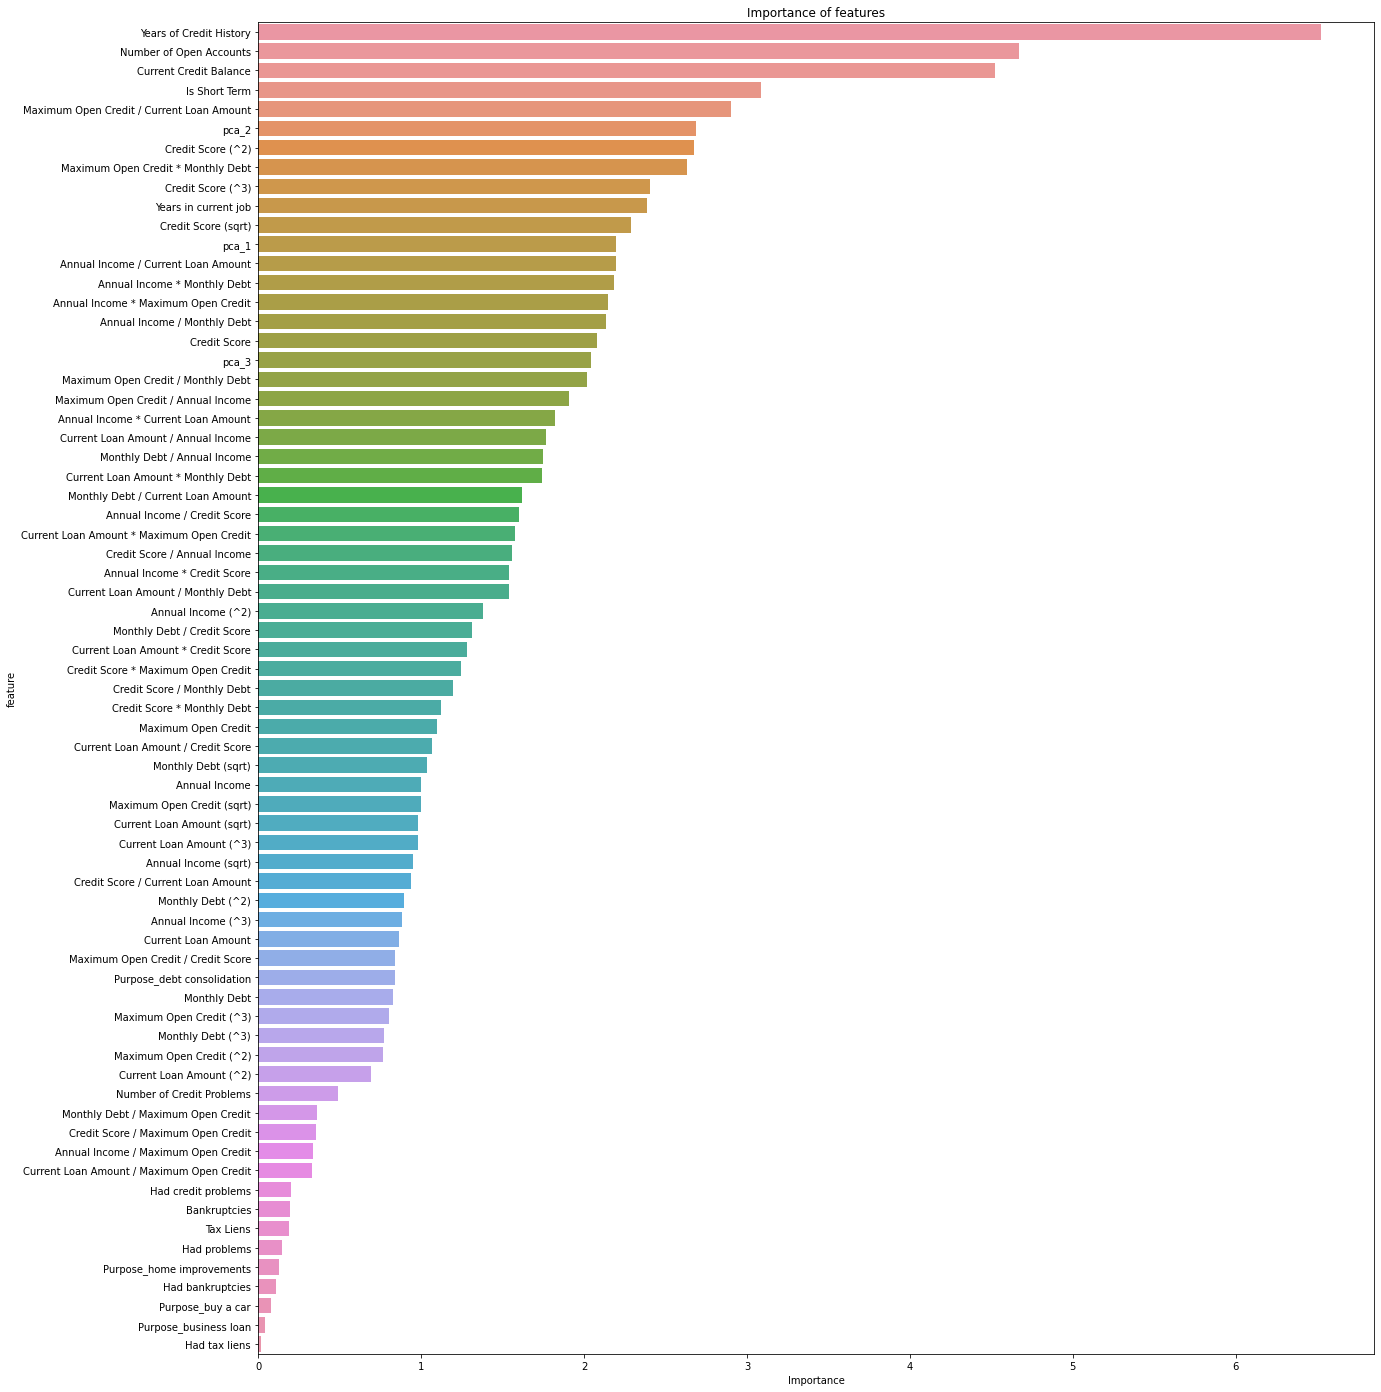

In [41]:
show_feature_importances(X.columns, model_catb.feature_importances_)

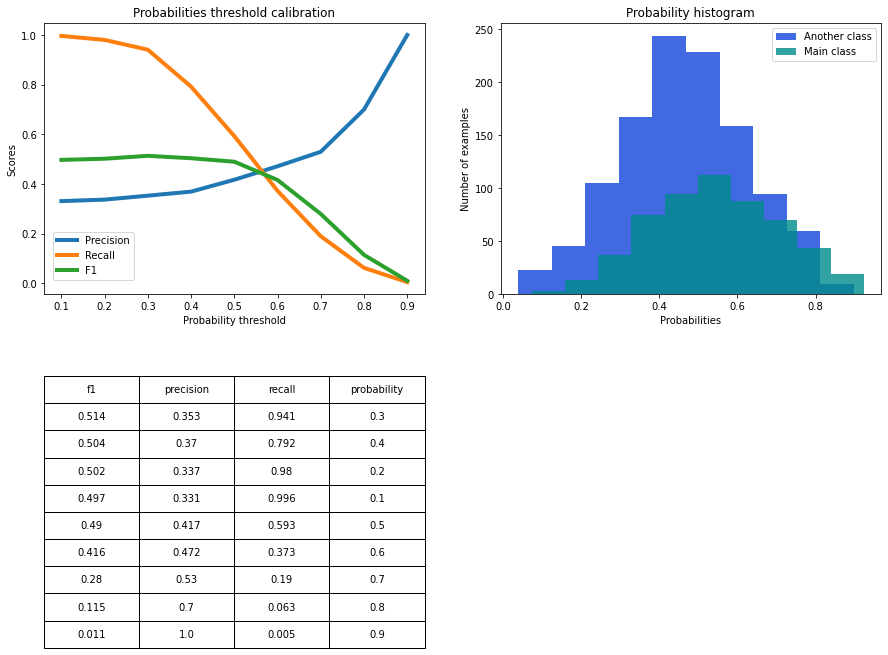

In [42]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Классификацию в данном решении можно делать по принципу
* **y_pred_probs[:,1] > 0.55**

### В данном решении:
* **Около 1000 наблюдений были удалены по принципу 3х интерквантильных размахов**
* **Не используется кластеризация для признаков,что может увеличить скор**
* **Используется всего одна модель из коробки**
### Используя все вышеописанное можно добиться лучших результатов для данного датасета. Мной же он использовался сугубо в учебных целях

**t.me/Mahhets**